Вопросы

1. Что такое UNet, FPN, почему они широко применяются в задачах сегментации?

2. Эксперимент с обучением неглубокого UNet

3. Эксперимент с обучением неглубокого UNet без skip-connections

4. Эксперимент с обучением более глубокого UNet

5. Эксперимент с обучением более глубокого UNet без skip-connections

6. Сравнение полученных результатов и выводы

Feature Pyramid Network (FPN): https://paperswithcode.com/method/fpn

UNet: https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/

Cсылка на датасет:
https://www.kaggle.com/datasets/zionfuo/drive2004

Я его скачал на устройство в сжатом формате и каждый раз загружаю в ноутбук

In [1]:
!unzip -q ./archive\ \(3\).zip

Импорты

In [2]:
import os
import time
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import numpy as np
import cv2
from tqdm import tqdm
import imageio
from albumentations import HorizontalFlip, VerticalFlip, Rotate
import numpy as np
from torch.utils.data import Dataset
import torch.nn.functional as F
import random
import numpy as np
from operator import add
from glob import glob
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm_notebook

Предобработка датасета

In [3]:

""" Create a directory """
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def load_data(path):
    train_x = sorted(glob(os.path.join(path, "training", "images", "*.tif")))
    train_y = sorted(glob(os.path.join(path, "training", "1st_manual", "*.gif")))

    test_x = sorted(glob(os.path.join(path, "test", "images", "*.tif")))
    test_y = sorted(glob(os.path.join(path, "test", "1st_manual", "*.gif")))

    return (train_x, train_y), (test_x, test_y)

def augment_data(images, masks, save_path, augment=True):
    size = (512, 512)

    for idx, (x, y) in tqdm(enumerate(zip(images, masks)), total=len(images)):
        """ Extracting the name """
        name = x.split("/")[-1].split(".")[0]

        """ Reading image and mask """
        x = cv2.imread(x, cv2.IMREAD_COLOR)
        y = imageio.mimread(y)[0]

        if augment == True:
            aug = HorizontalFlip(p=1.0)
            augmented = aug(image=x, mask=y)
            x1 = augmented["image"]
            y1 = augmented["mask"]

            aug = VerticalFlip(p=1.0)
            augmented = aug(image=x, mask=y)
            x2 = augmented["image"]
            y2 = augmented["mask"]

            aug = Rotate(limit=45, p=1.0)
            augmented = aug(image=x, mask=y)
            x3 = augmented["image"]
            y3 = augmented["mask"]

            X = [x, x1, x2, x3]
            Y = [y, y1, y2, y3]

        else:
            X = [x]
            Y = [y]

        index = 0
        for i, m in zip(X, Y):
            i = cv2.resize(i, size)
            m = cv2.resize(m, size)

            tmp_image_name = f"{name}_{index}.png"
            tmp_mask_name = f"{name}_{index}.png"

            image_path = os.path.join(save_path, "image", tmp_image_name)
            mask_path = os.path.join(save_path, "mask", tmp_mask_name)

            cv2.imwrite(image_path, i)
            cv2.imwrite(mask_path, m)

            index += 1

In [4]:
""" Seeding """
np.random.seed(42)

""" Load the data """
data_path = "./DRIVE/"
(train_x, train_y), (test_x, test_y) = load_data(data_path)

print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Test: {len(test_x)} - {len(test_y)}")

""" Create directories to save the augmented data """
create_dir("new_data/train/image/")
create_dir("new_data/train/mask/")
create_dir("new_data/test/image/")
create_dir("new_data/test/mask/")

""" Data augmentation """
augment_data(train_x, train_y, "new_data/train/", augment=True)
augment_data(test_x, test_y, "new_data/test/", augment=False)

Train: 20 - 20
Test: 20 - 20


100%|██████████| 20/20 [00:00<00:00, 31.50it/s]


In [5]:

class DriveDataset(Dataset):
    def __init__(self, images_path, masks_path):

        self.images_path = images_path
        self.masks_path = masks_path
        self.n_samples = len(images_path)

    def __getitem__(self, index):
        """ Reading image """
        image = cv2.imread(self.images_path[index], cv2.IMREAD_COLOR)
        image = image/255.0 ## (512, 512, 3)
        image = np.transpose(image, (2, 0, 1))  ## (3, 512, 512)
        image = image.astype(np.float32)
        image = torch.from_numpy(image)

        """ Reading mask """
        mask = cv2.imread(self.masks_path[index], cv2.IMREAD_GRAYSCALE)
        mask = mask/255.0   ## (512, 512)
        mask = np.expand_dims(mask, axis=0) ## (1, 512, 512)
        mask = mask.astype(np.float32)
        mask = torch.from_numpy(mask)

        return image, mask

    def __len__(self):
        return self.n_samples

Лосс

In [6]:

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

Блоки архитектуры UNet

In [43]:

class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x


class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p


#Для версии без skip connection
class encoder_block_w(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return p


class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x


#Для версии без skip connection
class decoder_block_w(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c, out_c)

    def forward(self, inputs):
        x = self.up(inputs)
        x = self.conv(x)
        return x

UNet

In [44]:
class build_unet(nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder """
        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)

        """ Bottleneck """
        self.b = conv_block(512, 1024)

        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        """ Classifier """
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        """ Bottleneck """
        b = self.b(p4)

        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        outputs = self.outputs(d4)

        return outputs


x = torch.randn((2, 3, 512, 512))
f = build_unet()
y = f(x)
print(y.shape)

torch.Size([2, 1, 512, 512])


UNet без skip connection

In [45]:
class build_unet_w(nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder """
        self.e1 = encoder_block_w(3, 64)
        self.e2 = encoder_block_w(64, 128)
        self.e3 = encoder_block_w(128, 256)
        self.e4 = encoder_block_w(256, 512)

        """ Bottleneck """
        self.b = conv_block(512, 1024)

        """ Decoder """
        self.d1 = decoder_block_w(1024, 512)
        self.d2 = decoder_block_w(512, 256)
        self.d3 = decoder_block_w(256, 128)
        self.d4 = decoder_block_w(128, 64)

        """ Classifier """
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def forward(self, inputs):
        """ Encoder """
        p1 = self.e1(inputs)
        p2 = self.e2(p1)
        p3 = self.e3(p2)
        p4 = self.e4(p3)

        """ Bottleneck """
        b = self.b(p4)

        """ Decoder """
        d1 = self.d1(b)
        d2 = self.d2(d1)
        d3 = self.d3(d2)
        d4 = self.d4(d3)

        outputs = self.outputs(d4)

        return outputs


x = torch.randn((2, 3, 512, 512))
f = build_unet_w()
y = f(x)
print(y.shape)

torch.Size([2, 1, 512, 512])


UNet с меньшим числом слоёв

In [46]:
class build_unet_l(nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder """
        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        #self.e3 = encoder_block(128, 256)
        #self.e4 = encoder_block(256, 512)

        """ Bottleneck """
        self.b = conv_block(128, 256)

        """ Decoder """
        #self.d1 = decoder_block(1024, 512)
        #self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        """ Classifier """
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        #s3, p3 = self.e3(p2)
        #s4, p4 = self.e4(p3)

        """ Bottleneck """
        b = self.b(p2)

        """ Decoder """
        #d1 = self.d1(b, s4)
        #d2 = self.d2(d1, s3)
        d3 = self.d3(b, s2)
        d4 = self.d4(d3, s1)

        outputs = self.outputs(d4)

        return outputs


x = torch.randn((2, 3, 512, 512))
f = build_unet_l()
y = f(x)
print(y.shape)

torch.Size([2, 1, 512, 512])


UNet с меньшим числом слоёв и без skip connection

In [47]:
class build_unet_l_w(nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder """
        self.e1 = encoder_block_w(3, 64)
        self.e2 = encoder_block_w(64, 128)
        #self.e3 = encoder_block(128, 256)
        #self.e4 = encoder_block(256, 512)

        """ Bottleneck """
        self.b = conv_block(128, 256)

        """ Decoder """
        #self.d1 = decoder_block(1024, 512)
        #self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block_w(256, 128)
        self.d4 = decoder_block_w(128, 64)

        """ Classifier """
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def forward(self, inputs):
        """ Encoder """
        p1 = self.e1(inputs)
        p2 = self.e2(p1)
        #s3, p3 = self.e3(p2)
        #s4, p4 = self.e4(p3)

        """ Bottleneck """
        b = self.b(p2)

        
        """ Decoder """
        #d1 = self.d1(b, s4)
        #d2 = self.d2(b3, s3)
        d3 = self.d3(b)
        d4 = self.d4(d3)

        outputs = self.outputs(d4)

        return outputs


x = torch.randn((2, 3, 512, 512))
f = build_unet_l_w()
y = f(x)
print(y.shape)

torch.Size([2, 1, 512, 512])


UNet с skip connection только на нижних слоях

In [68]:
class build_unet_w_1(nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder """
        self.e1 = encoder_block_w(3, 64)
        self.e2 = encoder_block_w(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)

        """ Bottleneck """
        self.b = conv_block(512, 1024)

        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block_w(256, 128)
        self.d4 = decoder_block_w(128, 64)

        """ Classifier """
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def forward(self, inputs):
        """ Encoder """
        p1 = self.e1(inputs)
        p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        """ Bottleneck """
        b = self.b(p4)

        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2)
        d4 = self.d4(d3)

        outputs = self.outputs(d4)

        return outputs


x = torch.randn((2, 3, 512, 512))
f = build_unet_w_1()
y = f(x)
print(y.shape)

torch.Size([2, 1, 512, 512])


UNet с skip connection только на верхних слоях

In [75]:
class build_unet_w_2(nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder """
        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block_w(128, 256)
        self.e4 = encoder_block_w(256, 512)

        """ Bottleneck """
        self.b = conv_block(512, 1024)

        """ Decoder """
        self.d1 = decoder_block_w(1024, 512)
        self.d2 = decoder_block_w(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        """ Classifier """
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        p3 = self.e3(p2)
        p4 = self.e4(p3)

        """ Bottleneck """
        b = self.b(p4)

        """ Decoder """
        d1 = self.d1(b)
        d2 = self.d2(d1)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        outputs = self.outputs(d4)

        return outputs


x = torch.randn((2, 3, 512, 512))
f = build_unet_w_2()
y = f(x)
print(y.shape)

torch.Size([2, 1, 512, 512])


In [48]:

""" Seeding the randomness. """
def seeding(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


""" Calculate the time taken """
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Функции обучения и валидации

In [49]:
def train(model, loader, optimizer, loss_fn, device):
    epoch_loss = 0.0

    model.train()
    for _, batch in enumerate(tqdm_notebook(loader)):
        x, y = batch
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss = epoch_loss/len(loader)
    return epoch_loss

def evaluate(model, loader, loss_fn, device):
    epoch_loss = 0.0

    model.eval()
    with torch.no_grad():
        for _, batch in enumerate(tqdm_notebook(loader)):
            x, y = batch
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.float32)

            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            epoch_loss += loss.item()

        epoch_loss = epoch_loss/len(loader)
    return epoch_loss

In [50]:
""" Seeding """
seeding(42)

""" Directories """
create_dir("files")

""" Load dataset """
train_x = sorted(glob("./new_data/train/image/*"))
train_y = sorted(glob("./new_data/train/mask/*"))

valid_x = sorted(glob("./new_data/test/image/*"))
valid_y = sorted(glob("./new_data/test/mask/*"))

data_str = f"Dataset Size:\nTrain: {len(train_x)} - Valid: {len(valid_x)}\n"
print(data_str)

Dataset Size:
Train: 80 - Valid: 20



In [78]:
""" Hyperparameters """
H = 512
W = 512
size = (H, W)
batch_size = 2
num_epochs = 10
lr = 1e-4
checkpoint_path_unet = "./files/checkpoint_unet.pth"
checkpoint_path_unet_l = "./files/checkpoint_unet_l.pth"
checkpoint_path_unet_w = "./files/checkpoint_unet_w.pth"
checkpoint_path_unet_l_w = "./files/checkpoint_unet_l_w.pth"
checkpoint_path_unet_w_1 = "./files/checkpoint_unet_w_1.pth"
checkpoint_path_unet_w_2 = "./files/checkpoint_unet_w_2.pth"
# checkpoint_path_unet_l1 = "./files/checkpoint_unet_l1.pth"
# checkpoint_path_segnet = "./files/checkpoint_segnet.pth"
# checkpoint_path_segnet_l = "./files/checkpoint_segnet_l.pth"


Даталоадеры

In [52]:
""" Dataset and loader """
train_dataset = DriveDataset(train_x, train_y)
valid_dataset = DriveDataset(valid_x, valid_y)

train_loader = DataLoader(
  dataset=train_dataset,
  batch_size=batch_size,
  shuffle=True,
  num_workers=2
)

valid_loader = DataLoader(
  dataset=valid_dataset,
  batch_size=batch_size,
  shuffle=False,
  num_workers=2
)

Выбор девайса

In [53]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Функции для оценки качкества

In [54]:
def calculate_metrics(y_true, y_pred):
    """ Ground truth """
    y_true = y_true.cpu().numpy()
    y_true = y_true > 0.5
    y_true = y_true.astype(np.uint8)
    y_true = y_true.reshape(-1)

    """ Prediction """
    y_pred = y_pred.cpu().numpy()
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.uint8)
    y_pred = y_pred.reshape(-1)

    score_jaccard = jaccard_score(y_true, y_pred)
    score_f1 = f1_score(y_true, y_pred)
    score_recall = recall_score(y_true, y_pred)
    score_precision = precision_score(y_true, y_pred)
    score_acc = accuracy_score(y_true, y_pred)

    return [score_jaccard, score_f1, score_recall, score_precision, score_acc]

def mask_parse(mask):
    mask = np.expand_dims(mask, axis=-1)    ## (512, 512, 1)
    mask = np.concatenate([mask, mask, mask], axis=-1)  ## (512, 512, 3)
    return mask


Функция обучения и оценки качества и сохранения результатов

In [55]:
def working(model, train_loader, valid_loader, optimizer, loss_fn, device, checkpoint_path, model_name, num_epochs):
    """ Training the model """
    best_valid_loss = float("inf")
    train_losses=[]
    valid_losses=[]
    for epoch in enumerate(tqdm_notebook(range(num_epochs))):
        epoch = epoch[0]
        start_time = time.time()

        train_loss = train(model, train_loader, optimizer, loss_fn, device)

        valid_loss = evaluate(model, valid_loader, loss_fn, device)

        """ Saving the model """
        if valid_loss < best_valid_loss:
            data_str = f"Valid loss improved from {best_valid_loss:2.4f} to {valid_loss:2.4f}. Saving checkpoint: {checkpoint_path}"
            print(data_str)

            best_valid_loss = valid_loss
            torch.save(model.state_dict(), checkpoint_path)

        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        data_str = f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s\n'
        data_str += f'\tTrain Loss: {train_loss:.3f}\n'
        train_losses.append(train_loss)
        data_str += f'\t Val. Loss: {valid_loss:.3f}\n'
        valid_losses.append(valid_loss)
        print(data_str)  

    """ Drawing loss """
    plt.figure(figsize=(10, 7))
    plt.plot(train_losses, label='Train')
    plt.plot(valid_losses, label='Validation')

    #plt.ylim(0, 0.05)
    plt.xlabel('Epoch')
    plt.title(model_name + ' loss')
    plt.legend()
    plt.show()

    """ Seeding """
    seeding(42)

    """ Folders """
    create_dir("results")

    """ Load dataset """
    test_x = sorted(glob("./new_data/test/image/*"))
    test_y = sorted(glob("./new_data/test/mask/*"))


    """ Hyperparameters """
    H = 512
    W = 512
    size = (W, H)

    """ Load the checkpoint """
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.eval()

    metrics_score = [0.0, 0.0, 0.0, 0.0, 0.0]
    time_taken = []

    for i, (x, y) in tqdm(enumerate(zip(test_x, test_y)), total=len(test_x)):
        """ Extract the name """
        name = x.split("/")[-1].split(".")[0]

        """ Reading image """
        image = cv2.imread(x, cv2.IMREAD_COLOR) ## (512, 512, 3)
        x = np.transpose(image, (2, 0, 1))      ## (3, 512, 512)
        x = x/255.0
        x = np.expand_dims(x, axis=0)           ## (1, 3, 512, 512)
        x = x.astype(np.float32)
        x = torch.from_numpy(x)
        x = x.to(device)

        """ Reading mask """
        mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)  ## (512, 512)
        y = np.expand_dims(mask, axis=0)            ## (1, 512, 512)
        y = y/255.0
        y = np.expand_dims(y, axis=0)               ## (1, 1, 512, 512)
        y = y.astype(np.float32)
        y = torch.from_numpy(y)
        y = y.to(device)

        folder_name = f"./results/{model_name}"
        if not os.path.exists(folder_name):
            os.makedirs(folder_name)

        with torch.no_grad():
            """ Prediction and Calculating FPS """
            start_time = time.time()
            pred_y = model(x)
            pred_y = torch.sigmoid(pred_y)
            total_time = time.time() - start_time
            time_taken.append(total_time)


            score = calculate_metrics(y, pred_y)
            metrics_score = list(map(add, metrics_score, score))
            pred_y = pred_y[0].cpu().numpy()        ## (1, 512, 512)
            pred_y = np.squeeze(pred_y, axis=0)     ## (512, 512)
            pred_y = pred_y > 0.5
            pred_y = np.array(pred_y, dtype=np.uint8)

        """ Saving masks """
        ori_mask = mask_parse(mask)
        pred_y = mask_parse(pred_y)
        line = np.ones((size[1], 10, 3)) * 128

        cat_images = np.concatenate(
            [image, line, ori_mask, line, pred_y * 255], axis=1
        )
        cv2.imwrite(f"./results/{model_name}/{name}.png", cat_images)
        #print(f"./results/{model_name}/{name}.png")

    jaccard = metrics_score[0]/len(test_x)
    f1 = metrics_score[1]/len(test_x)
    recall = metrics_score[2]/len(test_x)
    precision = metrics_score[3]/len(test_x)
    acc = metrics_score[4]/len(test_x)
    print(f"Jaccard: {jaccard:1.4f} - F1: {f1:1.4f} - Recall: {recall:1.4f} - Precision: {precision:1.4f} - Acc: {acc:1.4f}")

    fps = 1/np.mean(time_taken)
    print("FPS: ", fps)
    # загрузка изображения
    img = Image.open(f"./results/{model_name}/01_test_0.png")

    # преобразование в массив numpy
    img_array = np.array(img)

    # отображение изображения
    plt.imshow(img_array)
    plt.show()
 

Обучение UNet

In [56]:
model_unet = build_unet()
model_unet = model_unet.to(device)

optimizer_unet = torch.optim.AdamW(model_unet.parameters(), lr=lr)
scheduler_unet = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_unet, 'min', patience=5, verbose=True)
loss_fn = DiceBCELoss()

In [57]:
num_epochs = 10
model_name = 'UNet'

<ipython-input-55-005e597ae263>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in enumerate(tqdm_notebook(range(num_epochs))):


  0%|          | 0/10 [00:00<?, ?it/s]

<ipython-input-49-d6692adbdb7d>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _, batch in enumerate(tqdm_notebook(loader)):


  0%|          | 0/40 [00:00<?, ?it/s]

<ipython-input-49-d6692adbdb7d>:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _, batch in enumerate(tqdm_notebook(loader)):


  0%|          | 0/10 [00:00<?, ?it/s]

Valid loss improved from inf to 1.3347. Saving checkpoint: ./files/checkpoint_unet.pth
Epoch: 01 | Epoch Time: 0m 32s
	Train Loss: 1.166
	 Val. Loss: 1.335



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Valid loss improved from 1.3347 to 0.9807. Saving checkpoint: ./files/checkpoint_unet.pth
Epoch: 02 | Epoch Time: 0m 32s
	Train Loss: 0.982
	 Val. Loss: 0.981



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Valid loss improved from 0.9807 to 0.8872. Saving checkpoint: ./files/checkpoint_unet.pth
Epoch: 03 | Epoch Time: 0m 31s
	Train Loss: 0.921
	 Val. Loss: 0.887



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Valid loss improved from 0.8872 to 0.8517. Saving checkpoint: ./files/checkpoint_unet.pth
Epoch: 04 | Epoch Time: 0m 32s
	Train Loss: 0.875
	 Val. Loss: 0.852



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Valid loss improved from 0.8517 to 0.8146. Saving checkpoint: ./files/checkpoint_unet.pth
Epoch: 05 | Epoch Time: 0m 32s
	Train Loss: 0.837
	 Val. Loss: 0.815



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Valid loss improved from 0.8146 to 0.7716. Saving checkpoint: ./files/checkpoint_unet.pth
Epoch: 06 | Epoch Time: 0m 32s
	Train Loss: 0.798
	 Val. Loss: 0.772



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Valid loss improved from 0.7716 to 0.7450. Saving checkpoint: ./files/checkpoint_unet.pth
Epoch: 07 | Epoch Time: 0m 32s
	Train Loss: 0.761
	 Val. Loss: 0.745



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Valid loss improved from 0.7450 to 0.7283. Saving checkpoint: ./files/checkpoint_unet.pth
Epoch: 08 | Epoch Time: 0m 32s
	Train Loss: 0.728
	 Val. Loss: 0.728



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Valid loss improved from 0.7283 to 0.6727. Saving checkpoint: ./files/checkpoint_unet.pth
Epoch: 09 | Epoch Time: 0m 32s
	Train Loss: 0.698
	 Val. Loss: 0.673



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Valid loss improved from 0.6727 to 0.6569. Saving checkpoint: ./files/checkpoint_unet.pth
Epoch: 10 | Epoch Time: 0m 32s
	Train Loss: 0.666
	 Val. Loss: 0.657



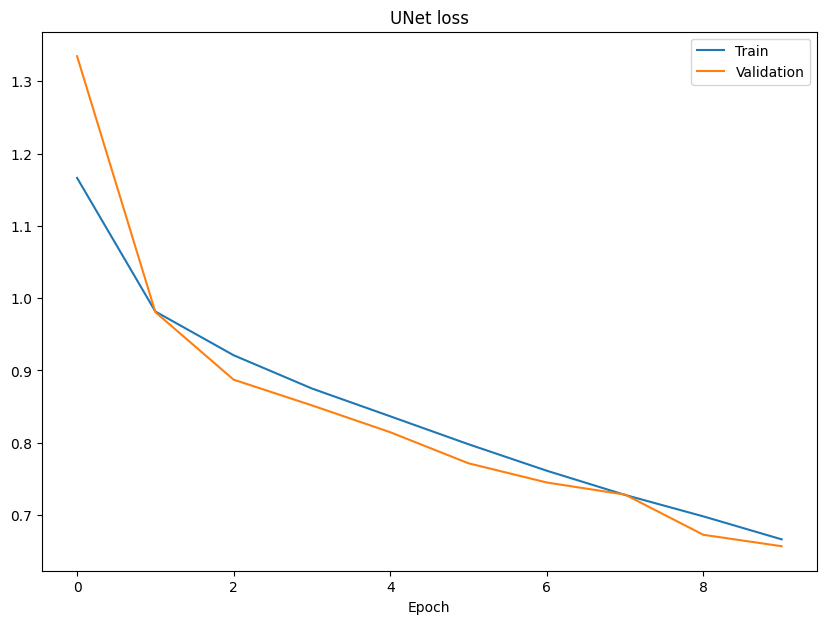

100%|██████████| 20/20 [00:08<00:00,  2.32it/s]


Jaccard: 0.6582 - F1: 0.7936 - Recall: 0.8076 - Precision: 0.7879 - Acc: 0.9636
FPS:  127.93518908267907


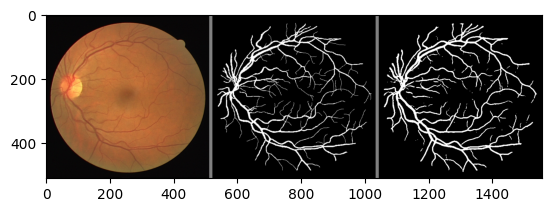

In [58]:
working(model_unet, train_loader, valid_loader, optimizer_unet, loss_fn, device, checkpoint_path_unet,  model_name, num_epochs)

Обучение UNet без skip connection

In [59]:
model_unet_w = build_unet_w()
model_unet_w = model_unet_w.to(device)

optimizer_unet_w = torch.optim.AdamW(model_unet_w.parameters(), lr=lr)
scheduler_unet_w = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_unet_w, 'min', patience=5, verbose=True)
loss_fn = DiceBCELoss()

In [60]:
num_epochs = 10
model_name = 'UNet_w'

<ipython-input-55-005e597ae263>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in enumerate(tqdm_notebook(range(num_epochs))):


  0%|          | 0/10 [00:00<?, ?it/s]

<ipython-input-49-d6692adbdb7d>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _, batch in enumerate(tqdm_notebook(loader)):


  0%|          | 0/40 [00:00<?, ?it/s]

<ipython-input-49-d6692adbdb7d>:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _, batch in enumerate(tqdm_notebook(loader)):


  0%|          | 0/10 [00:00<?, ?it/s]

Valid loss improved from inf to 1.3000. Saving checkpoint: ./files/checkpoint_unet_w.pth
Epoch: 01 | Epoch Time: 0m 28s
	Train Loss: 1.318
	 Val. Loss: 1.300



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Valid loss improved from 1.3000 to 1.0425. Saving checkpoint: ./files/checkpoint_unet_w.pth
Epoch: 02 | Epoch Time: 0m 28s
	Train Loss: 1.136
	 Val. Loss: 1.042



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Valid loss improved from 1.0425 to 0.9718. Saving checkpoint: ./files/checkpoint_unet_w.pth
Epoch: 03 | Epoch Time: 0m 28s
	Train Loss: 1.027
	 Val. Loss: 0.972



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Valid loss improved from 0.9718 to 0.9237. Saving checkpoint: ./files/checkpoint_unet_w.pth
Epoch: 04 | Epoch Time: 0m 28s
	Train Loss: 0.959
	 Val. Loss: 0.924



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Valid loss improved from 0.9237 to 0.8767. Saving checkpoint: ./files/checkpoint_unet_w.pth
Epoch: 05 | Epoch Time: 0m 28s
	Train Loss: 0.906
	 Val. Loss: 0.877



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Valid loss improved from 0.8767 to 0.8362. Saving checkpoint: ./files/checkpoint_unet_w.pth
Epoch: 06 | Epoch Time: 0m 28s
	Train Loss: 0.862
	 Val. Loss: 0.836



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Valid loss improved from 0.8362 to 0.8283. Saving checkpoint: ./files/checkpoint_unet_w.pth
Epoch: 07 | Epoch Time: 0m 28s
	Train Loss: 0.825
	 Val. Loss: 0.828



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Valid loss improved from 0.8283 to 0.8037. Saving checkpoint: ./files/checkpoint_unet_w.pth
Epoch: 08 | Epoch Time: 0m 28s
	Train Loss: 0.790
	 Val. Loss: 0.804



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Valid loss improved from 0.8037 to 0.7692. Saving checkpoint: ./files/checkpoint_unet_w.pth
Epoch: 09 | Epoch Time: 0m 28s
	Train Loss: 0.754
	 Val. Loss: 0.769



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Valid loss improved from 0.7692 to 0.7434. Saving checkpoint: ./files/checkpoint_unet_w.pth
Epoch: 10 | Epoch Time: 0m 28s
	Train Loss: 0.725
	 Val. Loss: 0.743



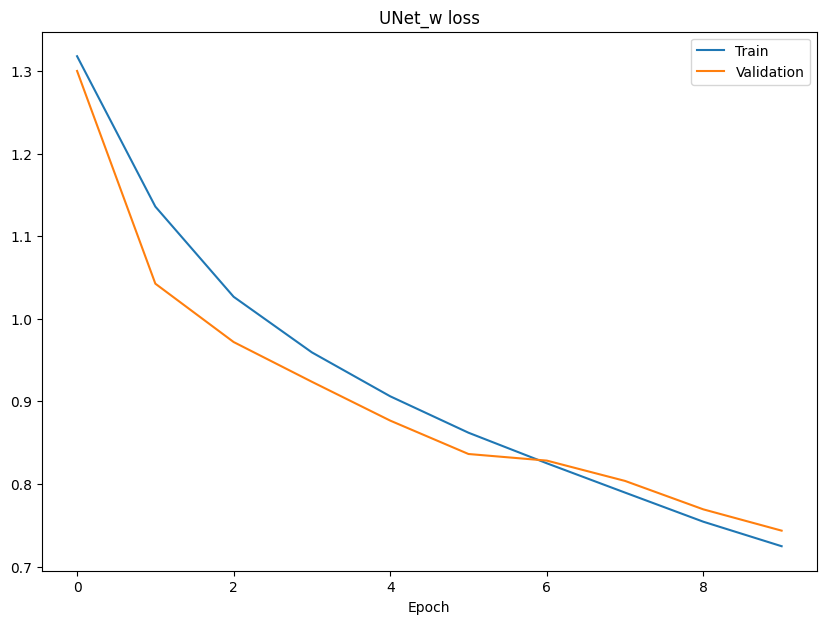

100%|██████████| 20/20 [00:08<00:00,  2.24it/s]


Jaccard: 0.5584 - F1: 0.7164 - Recall: 0.7120 - Precision: 0.7282 - Acc: 0.9511
FPS:  120.71033777162535


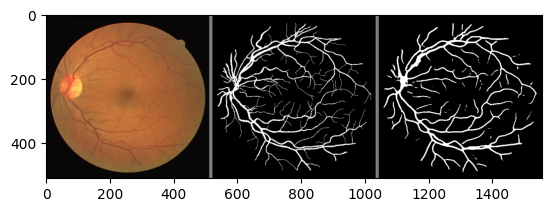

In [61]:
working(model_unet_w, train_loader, valid_loader, optimizer_unet_w, loss_fn, device, checkpoint_path_unet_w,  model_name, num_epochs)

Обучение UNet с меньшим числом слоёв

In [62]:
model_unet_l = build_unet_l()
model_unet_l = model_unet_l.to(device)

optimizer_unet_l = torch.optim.AdamW(model_unet_l.parameters(), lr=lr)
scheduler_unet_l = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_unet_l, 'min', patience=5, verbose=True)
loss_fn = DiceBCELoss()

In [63]:
num_epochs = 10
model_name = 'UNet_l'

<ipython-input-55-005e597ae263>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in enumerate(tqdm_notebook(range(num_epochs))):


  0%|          | 0/10 [00:00<?, ?it/s]

<ipython-input-49-d6692adbdb7d>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _, batch in enumerate(tqdm_notebook(loader)):


  0%|          | 0/40 [00:00<?, ?it/s]

<ipython-input-49-d6692adbdb7d>:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _, batch in enumerate(tqdm_notebook(loader)):


  0%|          | 0/10 [00:00<?, ?it/s]

Valid loss improved from inf to 1.2930. Saving checkpoint: ./files/checkpoint_unet_l.pth
Epoch: 01 | Epoch Time: 0m 22s
	Train Loss: 1.176
	 Val. Loss: 1.293



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Valid loss improved from 1.2930 to 0.9352. Saving checkpoint: ./files/checkpoint_unet_l.pth
Epoch: 02 | Epoch Time: 0m 22s
	Train Loss: 0.952
	 Val. Loss: 0.935



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Valid loss improved from 0.9352 to 0.8827. Saving checkpoint: ./files/checkpoint_unet_l.pth
Epoch: 03 | Epoch Time: 0m 22s
	Train Loss: 0.893
	 Val. Loss: 0.883



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Valid loss improved from 0.8827 to 0.8461. Saving checkpoint: ./files/checkpoint_unet_l.pth
Epoch: 04 | Epoch Time: 0m 22s
	Train Loss: 0.848
	 Val. Loss: 0.846



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Valid loss improved from 0.8461 to 0.7841. Saving checkpoint: ./files/checkpoint_unet_l.pth
Epoch: 05 | Epoch Time: 0m 22s
	Train Loss: 0.807
	 Val. Loss: 0.784



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Valid loss improved from 0.7841 to 0.7586. Saving checkpoint: ./files/checkpoint_unet_l.pth
Epoch: 06 | Epoch Time: 0m 22s
	Train Loss: 0.771
	 Val. Loss: 0.759



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Valid loss improved from 0.7586 to 0.7291. Saving checkpoint: ./files/checkpoint_unet_l.pth
Epoch: 07 | Epoch Time: 0m 22s
	Train Loss: 0.741
	 Val. Loss: 0.729



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Valid loss improved from 0.7291 to 0.6989. Saving checkpoint: ./files/checkpoint_unet_l.pth
Epoch: 08 | Epoch Time: 0m 22s
	Train Loss: 0.711
	 Val. Loss: 0.699



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Valid loss improved from 0.6989 to 0.6688. Saving checkpoint: ./files/checkpoint_unet_l.pth
Epoch: 09 | Epoch Time: 0m 22s
	Train Loss: 0.680
	 Val. Loss: 0.669



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Valid loss improved from 0.6688 to 0.6360. Saving checkpoint: ./files/checkpoint_unet_l.pth
Epoch: 10 | Epoch Time: 0m 22s
	Train Loss: 0.651
	 Val. Loss: 0.636



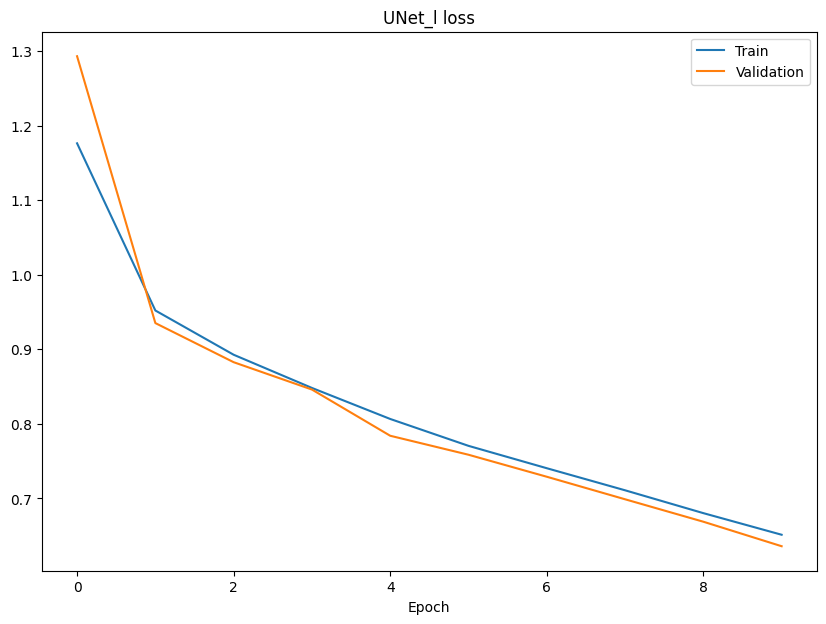

100%|██████████| 20/20 [00:08<00:00,  2.29it/s]


Jaccard: 0.6429 - F1: 0.7822 - Recall: 0.8159 - Precision: 0.7597 - Acc: 0.9606
FPS:  139.65418615878934


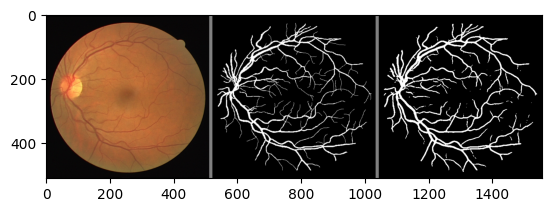

In [64]:
working(model_unet_l, train_loader, valid_loader, optimizer_unet_l, loss_fn, device, checkpoint_path_unet_l,  model_name, num_epochs)

Обучение UNet с меньшим чилом слоёв и без skip connection 

In [65]:
model_unet_l_w = build_unet_l_w()
model_unet_l_w = model_unet_l_w.to(device)

optimizer_unet_l_w = torch.optim.AdamW(model_unet_l_w.parameters(), lr=lr)
scheduler_unet_l_w = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_unet_l_w, 'min', patience=5, verbose=True)
loss_fn = DiceBCELoss()

In [66]:
num_epochs = 10
model_name = 'UNet_l_w'

<ipython-input-55-005e597ae263>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in enumerate(tqdm_notebook(range(num_epochs))):


  0%|          | 0/10 [00:00<?, ?it/s]

<ipython-input-49-d6692adbdb7d>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _, batch in enumerate(tqdm_notebook(loader)):


  0%|          | 0/40 [00:00<?, ?it/s]

<ipython-input-49-d6692adbdb7d>:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _, batch in enumerate(tqdm_notebook(loader)):


  0%|          | 0/10 [00:00<?, ?it/s]

Valid loss improved from inf to 1.2372. Saving checkpoint: ./files/checkpoint_unet_l_w.pth
Epoch: 01 | Epoch Time: 0m 20s
	Train Loss: 1.200
	 Val. Loss: 1.237



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Valid loss improved from 1.2372 to 0.9377. Saving checkpoint: ./files/checkpoint_unet_l_w.pth
Epoch: 02 | Epoch Time: 0m 20s
	Train Loss: 0.975
	 Val. Loss: 0.938



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Valid loss improved from 0.9377 to 0.8623. Saving checkpoint: ./files/checkpoint_unet_l_w.pth
Epoch: 03 | Epoch Time: 0m 20s
	Train Loss: 0.907
	 Val. Loss: 0.862



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Valid loss improved from 0.8623 to 0.8234. Saving checkpoint: ./files/checkpoint_unet_l_w.pth
Epoch: 04 | Epoch Time: 0m 20s
	Train Loss: 0.858
	 Val. Loss: 0.823



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Valid loss improved from 0.8234 to 0.8004. Saving checkpoint: ./files/checkpoint_unet_l_w.pth
Epoch: 05 | Epoch Time: 0m 20s
	Train Loss: 0.816
	 Val. Loss: 0.800



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Valid loss improved from 0.8004 to 0.7724. Saving checkpoint: ./files/checkpoint_unet_l_w.pth
Epoch: 06 | Epoch Time: 0m 20s
	Train Loss: 0.779
	 Val. Loss: 0.772



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Valid loss improved from 0.7724 to 0.7679. Saving checkpoint: ./files/checkpoint_unet_l_w.pth
Epoch: 07 | Epoch Time: 0m 20s
	Train Loss: 0.747
	 Val. Loss: 0.768



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Valid loss improved from 0.7679 to 0.6948. Saving checkpoint: ./files/checkpoint_unet_l_w.pth
Epoch: 08 | Epoch Time: 0m 20s
	Train Loss: 0.716
	 Val. Loss: 0.695



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Valid loss improved from 0.6948 to 0.6740. Saving checkpoint: ./files/checkpoint_unet_l_w.pth
Epoch: 09 | Epoch Time: 0m 20s
	Train Loss: 0.686
	 Val. Loss: 0.674



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Valid loss improved from 0.6740 to 0.6385. Saving checkpoint: ./files/checkpoint_unet_l_w.pth
Epoch: 10 | Epoch Time: 0m 20s
	Train Loss: 0.658
	 Val. Loss: 0.639



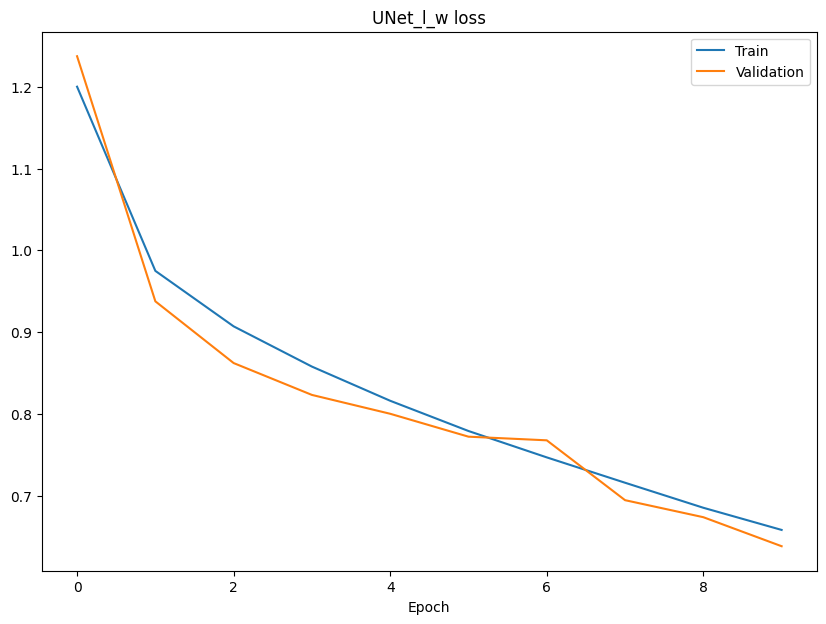

100%|██████████| 20/20 [00:08<00:00,  2.34it/s]


Jaccard: 0.6344 - F1: 0.7760 - Recall: 0.8273 - Precision: 0.7385 - Acc: 0.9586
FPS:  142.6551525932174


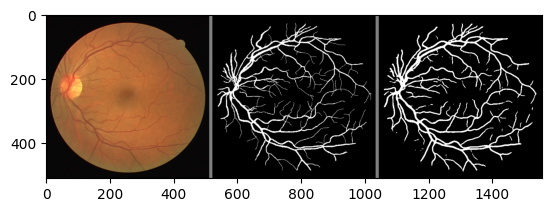

In [67]:
working(model_unet_l_w, train_loader, valid_loader, optimizer_unet_l_w, loss_fn, device, checkpoint_path_unet_l_w,  model_name, num_epochs)

Обучение UNet с skip connection только на нижних слоях

In [69]:
model_unet_w_1 = build_unet_w_1()
model_unet_w_1 = model_unet_w_1.to(device)

optimizer_unet_w_1 = torch.optim.AdamW(model_unet_w_1.parameters(), lr=lr)
scheduler_unet_w_1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_unet_w_1, 'min', patience=5, verbose=True)
loss_fn = DiceBCELoss()

In [70]:
num_epochs = 10
model_name = 'UNet_w_1'

<ipython-input-55-005e597ae263>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in enumerate(tqdm_notebook(range(num_epochs))):


  0%|          | 0/10 [00:00<?, ?it/s]

<ipython-input-49-d6692adbdb7d>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _, batch in enumerate(tqdm_notebook(loader)):


  0%|          | 0/40 [00:00<?, ?it/s]

<ipython-input-49-d6692adbdb7d>:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _, batch in enumerate(tqdm_notebook(loader)):


  0%|          | 0/10 [00:00<?, ?it/s]

Valid loss improved from inf to 1.2844. Saving checkpoint: ./files/checkpoint_unet_w_1.pth
Epoch: 01 | Epoch Time: 0m 30s
	Train Loss: 1.254
	 Val. Loss: 1.284



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Valid loss improved from 1.2844 to 0.9794. Saving checkpoint: ./files/checkpoint_unet_w_1.pth
Epoch: 02 | Epoch Time: 0m 30s
	Train Loss: 1.021
	 Val. Loss: 0.979



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Valid loss improved from 0.9794 to 0.9309. Saving checkpoint: ./files/checkpoint_unet_w_1.pth
Epoch: 03 | Epoch Time: 0m 29s
	Train Loss: 0.952
	 Val. Loss: 0.931



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Valid loss improved from 0.9309 to 0.8810. Saving checkpoint: ./files/checkpoint_unet_w_1.pth
Epoch: 04 | Epoch Time: 0m 30s
	Train Loss: 0.907
	 Val. Loss: 0.881



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Valid loss improved from 0.8810 to 0.8377. Saving checkpoint: ./files/checkpoint_unet_w_1.pth
Epoch: 05 | Epoch Time: 0m 30s
	Train Loss: 0.863
	 Val. Loss: 0.838



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Valid loss improved from 0.8377 to 0.8050. Saving checkpoint: ./files/checkpoint_unet_w_1.pth
Epoch: 06 | Epoch Time: 0m 30s
	Train Loss: 0.829
	 Val. Loss: 0.805



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Valid loss improved from 0.8050 to 0.7742. Saving checkpoint: ./files/checkpoint_unet_w_1.pth
Epoch: 07 | Epoch Time: 0m 30s
	Train Loss: 0.796
	 Val. Loss: 0.774



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Valid loss improved from 0.7742 to 0.7510. Saving checkpoint: ./files/checkpoint_unet_w_1.pth
Epoch: 08 | Epoch Time: 0m 30s
	Train Loss: 0.769
	 Val. Loss: 0.751



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Valid loss improved from 0.7510 to 0.7217. Saving checkpoint: ./files/checkpoint_unet_w_1.pth
Epoch: 09 | Epoch Time: 0m 30s
	Train Loss: 0.739
	 Val. Loss: 0.722



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Valid loss improved from 0.7217 to 0.6980. Saving checkpoint: ./files/checkpoint_unet_w_1.pth
Epoch: 10 | Epoch Time: 0m 30s
	Train Loss: 0.713
	 Val. Loss: 0.698



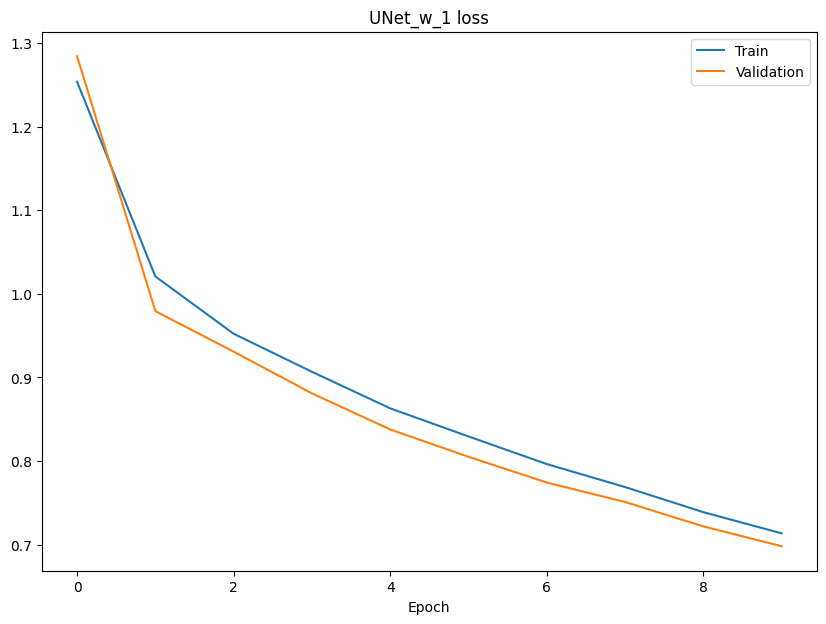

100%|██████████| 20/20 [00:08<00:00,  2.23it/s]


Jaccard: 0.6518 - F1: 0.7890 - Recall: 0.8227 - Precision: 0.7642 - Acc: 0.9618
FPS:  120.30610722931654


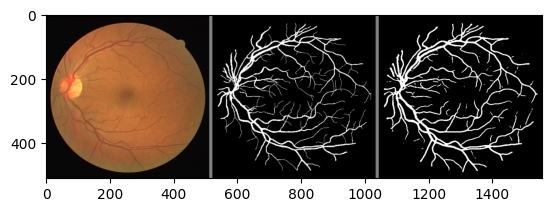

In [73]:
working(model_unet_w_1, train_loader, valid_loader, optimizer_unet_w_1, loss_fn, device, checkpoint_path_unet_w_1,  model_name, num_epochs)

Обучение UNet с skip connection только на верхних слоях

In [76]:
model_unet_w_2 = build_unet_w_2()
model_unet_w_2 = model_unet_w_2.to(device)

optimizer_unet_w_2 = torch.optim.AdamW(model_unet_w_2.parameters(), lr=lr)
scheduler_unet_w_2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_unet_w_2, 'min', patience=5, verbose=True)
loss_fn = DiceBCELoss()

In [80]:
num_epochs = 10
model_name = 'UNet_w_2'

<ipython-input-55-005e597ae263>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in enumerate(tqdm_notebook(range(num_epochs))):


  0%|          | 0/10 [00:00<?, ?it/s]

<ipython-input-49-d6692adbdb7d>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _, batch in enumerate(tqdm_notebook(loader)):


  0%|          | 0/40 [00:00<?, ?it/s]

<ipython-input-49-d6692adbdb7d>:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _, batch in enumerate(tqdm_notebook(loader)):


  0%|          | 0/10 [00:00<?, ?it/s]

Valid loss improved from inf to 1.2560. Saving checkpoint: ./files/checkpoint_unet_w_2.pth
Epoch: 01 | Epoch Time: 0m 31s
	Train Loss: 1.161
	 Val. Loss: 1.256



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Valid loss improved from 1.2560 to 0.9976. Saving checkpoint: ./files/checkpoint_unet_w_2.pth
Epoch: 02 | Epoch Time: 0m 30s
	Train Loss: 1.020
	 Val. Loss: 0.998



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Valid loss improved from 0.9976 to 0.9424. Saving checkpoint: ./files/checkpoint_unet_w_2.pth
Epoch: 03 | Epoch Time: 0m 30s
	Train Loss: 0.971
	 Val. Loss: 0.942



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Valid loss improved from 0.9424 to 0.8974. Saving checkpoint: ./files/checkpoint_unet_w_2.pth
Epoch: 04 | Epoch Time: 0m 30s
	Train Loss: 0.933
	 Val. Loss: 0.897



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Valid loss improved from 0.8974 to 0.8716. Saving checkpoint: ./files/checkpoint_unet_w_2.pth
Epoch: 05 | Epoch Time: 0m 30s
	Train Loss: 0.898
	 Val. Loss: 0.872



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Valid loss improved from 0.8716 to 0.8434. Saving checkpoint: ./files/checkpoint_unet_w_2.pth
Epoch: 06 | Epoch Time: 0m 30s
	Train Loss: 0.866
	 Val. Loss: 0.843



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Valid loss improved from 0.8434 to 0.7954. Saving checkpoint: ./files/checkpoint_unet_w_2.pth
Epoch: 07 | Epoch Time: 0m 30s
	Train Loss: 0.833
	 Val. Loss: 0.795



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Valid loss improved from 0.7954 to 0.7918. Saving checkpoint: ./files/checkpoint_unet_w_2.pth
Epoch: 08 | Epoch Time: 0m 30s
	Train Loss: 0.800
	 Val. Loss: 0.792



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 30s
	Train Loss: 0.770
	 Val. Loss: 1.013



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Valid loss improved from 0.7918 to 0.7324. Saving checkpoint: ./files/checkpoint_unet_w_2.pth
Epoch: 10 | Epoch Time: 0m 30s
	Train Loss: 0.751
	 Val. Loss: 0.732



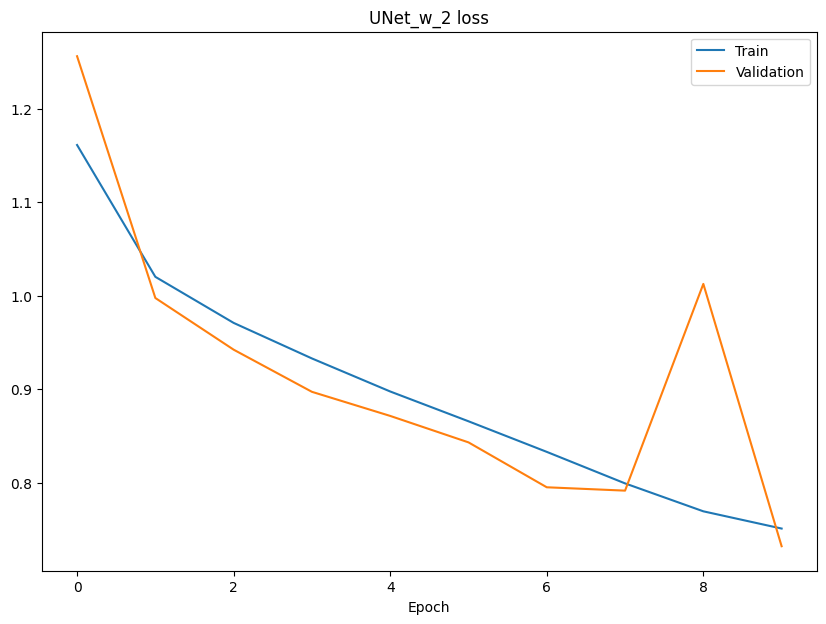

100%|██████████| 20/20 [00:09<00:00,  2.22it/s]


Jaccard: 0.6334 - F1: 0.7750 - Recall: 0.8058 - Precision: 0.7577 - Acc: 0.9595
FPS:  128.6298418617774


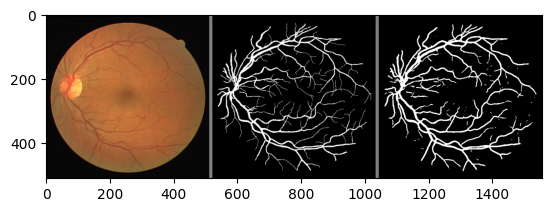

In [81]:
working(model_unet_w_2, train_loader, valid_loader, optimizer_unet_w_2, loss_fn, device, checkpoint_path_unet_w_2,  model_name, num_epochs)

**Результаты:**

1) UNet: 

  - Jaccard: 0.6582

  - F1: 0.7936

  - Recall: 0.8076

  - Precision: 0.7879

  - Acc: 0.9636

  - FPS:  127.9352

2) UNet с меньшим числом слоёв:

  - Jaccard: 0.6429 

  - F1: 0.7822 

  - Recall: 0.8159 

  - Precision: 0.7597 

  - Acc: 0.9606

  - FPS:  139.6542

3) UNet без skip connection:

  - Jaccard: 0.5584 

  - F1: 0.7164 

  - Recall: 0.7120 

  - Precision: 0.7282 

  - Acc: 0.9511

  - FPS:  120.7103

4) UNet с меньшим числом слоёв и без skip connection:

  - Jaccard: 0.6344

  - F1: 0.7760

  - Recall: 0.8273 

  - Precision: 0.7385 

  - Acc: 0.9586

  - FPS:  142.6552

5) UNet c skip connection только на нихних слоях:

  - Jaccard: 0.6518

  - F1: 0.7890

  - Recall: 0.8227

  - Precision: 0.7642

  - Acc: 0.9618

  - FPS:  120.3061

6) UNet с skip connection только на верхних слоях:

  - Jaccard: 0.6334

  - F1: 0.7750

  - Recall: 0.8058

  - Precision: 0.7577 

  - Acc: 0.9595

  - FPS:  128.6298

**Выводы:**

В данном случае наиболее валидной метрикой для оценки качества модели является F1-мера. Ранжируем архитектуры по ней:


1) UNet: 0.7936

2) UNet c skip connection только на нихних слоях: 0.7890

3) UNet с меньшим числом слоёв:  0.7822

4) UNet с меньшим числом слоёв и без skip connection: 0.7760

5) UNet с skip connection только на верхних слоях: 0.7750

6) UNet без skip connection: 0.7164


Таким образом, наиболее важны для нас skip connection на нижних слоях, а их добавление на верхних слоях может ухудшить модель. Глубина модели вторична.